<a id='home'></a>
### purpose 

Validate gradient forest models. 

Models were trained using individuals or their population allele frequencies ('ind' or 'pooled'). see `../01_train_gradient_forests.ipynb`

Using each set of individuals or pools, we trained models using either all loci or only those known to be under selection from the environment. see `../01_train_gradient_forests.ipynb`

We then fit these models to the climates of each source population. see `../02_fit_gradient_forests.ipynb`

Gather the predicted offset from these models and correlate with known fitness from simulations.


### outline

1. [get sample info](#samp)
    - get information about the samples used in the simulation
1. [load fitness data](#fitness)
    - get fitness of individuals or populations reciprocally transplanted
1. [gather offset predictions](#gather)
    - get the predicted offset output from Gradient Forests
1. [visualize validation](#viz)
    - calculate performance at common garden sites (correlate predicted offset of all populations at this site with the simulated fitness at this site) and performance across common garden sites (correlate predicted offset for an individual or pool with their simulated fitness across all common gardens)
    
    
    - create histograms for performance of individuals or pools at each garden
    - create histograms for performance of source populations across all gardens
    - create heatmaps for performance across samples at a common garden site
    - create heatmaps for source population performance across common gardens
        - for individual data, averages are taken on per-pop basis
1. [visualize environments](#envs)
    - create heatmaps of the environmental value across the simulated landscape

In [1]:
from pythonimports import *
from myfigs import save_pdf

from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from scipy.stats import linregress

DIR = '/work/lotterhos/MVP-Offsets/practice_slim/'
slimdir = op.join(DIR, 'mypractice')
garden_dir = makedir(op.join(DIR, 'fitting/gradient_forests/garden_files'))
fig_dir = makedir(op.join(DIR, 'fitting/gradient_forests/figs'))
fitting_dir = makedir(op.join(op.dirname(garden_dir), 'fitting_outfiles'))
training_outdir = op.join(DIR, 'training/gradient_forests/training_outfiles')

t1 = dt.now()  # notebook timer

latest_commit()
session_info.show()

##################################################################
Current commit of pythonimports:
commit 96972e25ae79fd576dc4d408930980b498b722b3  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Feb 18 12:27:11 2022 -0500
Today:	February 18, 2022 - 15:44:08
python version: 3.8.5
##################################################################



In [2]:
seed = '1231094'

<a id='samp'></a>
# get sample info

[top](#home)

In [3]:
# get a list of subsampled individuals, map samp top subpopID, and get population locations for each subpopID

# read in sample data
subset = pd.read_table(op.join(slimdir, f'{seed}_Rout_ind_subset.txt'),
                       delim_whitespace=True)
subset.index = ('i' + subset['indID'].astype(str)).tolist()  # this will match to the 'causal' file
subset['sample_name'] = subset.index.tolist()

# map subpopID to list of samps - key = subpopID val = list of individual sample names
popsamps = subset.groupby('subpopID')['sample_name'].apply(list).to_dict()

# map samp to subpopID
samppop = dict(zip(subset.index, subset['subpopID']))

# population locations
locations = subset.groupby('subpop')[['x', 'y']].apply(np.mean)
print(ColorText('locations').bold())
display(locations.head())

print(ColorText('\n\nsubset').bold())
subset.head()

locations


,x,y
subpop,,
1,1.0,1.0
2,2.0,1.0
3,3.0,1.0
4,4.0,1.0
5,5.0,1.0




subset


,seed,subpopID,indID,indSubpopIndex,subpop,phen_sal,phen_temp,sal_opt,temp_opt,fitness,subset,N,opt0,opt1,x,y,PC1,PC2,PC3,LFMM_U1_temp,LFMM_U1_sal,LFMM_U2_temp,LFMM_U2_sal,RDA1,RDA2,RDA_PC1,RDA_PC2,RDA_predict_tempPhen_20KSNPs,RDA_predict_salPhen_20KSNPs,sample_name
i0,1231094,1,0,0,1,0,-1.088090,-1.0,-1.0,0.984601,True,10,-1.0,-1.0,1,1,92.2154,-57.5673,-42.4980,-38.876285,72.935933,14.058057,40.216243,-2.464484,-4.413873,-2.401906,-2.096819,-5924.695082,-64.166353,i0
i1,1231094,1,1,1,1,0,-0.771927,-1.0,-1.0,0.901194,True,10,-1.0,-1.0,1,1,92.5184,-58.2218,-44.4978,-39.042619,73.119916,15.385371,40.384374,-2.472104,-3.013454,-2.412105,-2.206939,-5943.060707,-49.737004,i1
i2,1231094,1,2,2,1,0,-0.883133,-1.0,-1.0,0.973054,True,10,-1.0,-1.0,1,1,92.7162,-59.2298,-43.8789,-40.110397,73.313012,14.814410,41.455827,-2.478389,-3.995747,-2.476676,-2.159522,-5958.136915,-59.945481,i2
i3,1231094,1,3,3,1,0,-0.836002,-1.0,-1.0,0.947630,True,10,-1.0,-1.0,1,1,90.1391,-54.8804,-40.6813,-36.756808,71.370522,13.047852,38.074237,-2.409776,-2.373063,-2.273755,-2.013461,-5793.238241,-42.644448,i3
i4,1231094,1,4,4,1,0,-1.078760,-1.0,-1.0,0.987670,True,10,-1.0,-1.0,1,1,91.8586,-56.6580,-42.9090,-38.019264,72.297632,14.507998,39.346027,-2.443488,-4.116506,-2.350035,-2.134117,-5874.228034,-60.932578,i4


<a id='fitness'></a>
# load fitness data

[top](#home)

In [4]:
# load fitness matrices
fitness_mat = {}


### INDIVIDUAL
# an n_deme (rows) x n_individuals(columns) matrix with entries for fitness of individual in deme
# first row is a map to subpopID, so remove this
fitness_mat['ind'] = pd.read_table(op.join(slimdir, f'{seed}_fitnessmat_ind.txt'),
                                   delim_whitespace=True,
                                   header=None)
# remove the first row which maps individuals (columns) to subpopID (cell entries)
fitness_mat['ind'] = fitness_mat['ind'].drop([0])
# name individuals
fitness_mat['ind'].columns = ('i' + fitness_mat['ind'].columns.astype(str)).tolist()
# reduce to only the subsampled individuals
fitness_mat['ind'] = fitness_mat['ind'][subset.index]

print(ColorText('individual').bold())
print(f"{fitness_mat['ind'].shape = }")
display(fitness_mat['ind'].head())


#### POOLED
# an n_deme x n_deme table that indicates the mean fitness of individuals 
    # from the source deme (in columns) in the transplant deme (in rows)     
fitness_mat['pooled'] = pd.read_table(op.join(slimdir, f'{seed}_fitnessmat.txt'),
                                      delim_whitespace=True,
                                      header=None)
# set column names for subpopID
fitness_mat['pooled'].columns = range(1, 101, 1)
fitness_mat['pooled'].index = range(1, 101, 1)

print(ColorText('pooled').bold())
print(f"{fitness_mat['pooled'].shape = }")
fitness_mat['pooled'].head()

individual
fitness_mat['ind'].shape = (100, 1000)


,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,i11,i12,i13,i14,i15,i18,i19,i20,i21,i22,i32,i33,i35,i36,i37,i39,i43,i45,i46,i48,i56,i59,i61,i68,i74,i75,i81,i84,i88,i89,i92,i97,i103,i109,i113,i118,i122,i123,i127,i132,...,i9911,i9912,i9914,i9915,i9918,i9920,i9921,i9925,i9926,i9929,i9951,i9956,i9961,i9964,i9969,i9978,i9979,i9980,i9983,i9985,i9987,i9990,i9994,i9995,i10000,i10002,i10003,i10004,i10005,i10010,i10015,i10016,i10017,i10018,i10020,i10021,i10023,i10024,i10026,i10027,i10030,i10031,i10032,i10033,i10034,i10035,i10036,i10037,i10038,i10039
1,0.984601,0.901194,0.973054,0.94763,0.98767,0.99507,0.905252,0.91517,0.993613,0.999367,0.943707,0.999871,0.940303,0.987779,0.999387,0.997205,0.994886,0.999441,0.974814,0.92126,0.981606,0.93274,0.995926,0.994159,0.997067,0.985403,0.929457,0.999865,0.999267,0.989639,0.981591,0.942972,0.950514,0.994989,0.975356,0.988627,0.999106,0.974908,0.967942,0.999679,0.962198,0.983114,0.999501,0.972227,0.999835,0.922688,0.998827,0.835256,0.998364,0.994619,...,0.00008,0.000331,0.000215,0.000216,0.000554,0.000054,0.001391,0.000788,0.000451,0.000606,0.000271,0.001479,0.000225,0.000394,0.000502,0.000247,0.000383,0.00056,0.000976,0.001193,0.000043,0.000062,0.000335,0.000151,0.000199,0.000721,0.000298,0.000067,0.000199,0.000077,0.000273,0.000753,0.000478,0.000208,0.000994,0.000207,0.00002,0.000042,0.000231,0.000087,0.00024,0.00004,0.000445,0.000301,0.000136,0.000295,0.00003,0.000172,0.000637,0.000289
2,0.984601,0.901194,0.973054,0.94763,0.98767,0.99507,0.905252,0.91517,0.993613,0.999367,0.943707,0.999871,0.940303,0.987779,0.999387,0.997205,0.994886,0.999441,0.974814,0.92126,0.981606,0.93274,0.995926,0.994159,0.997067,0.985403,0.929457,0.999865,0.999267,0.989639,0.981591,0.942972,0.950514,0.994989,0.975356,0.988627,0.999106,0.974908,0.967942,0.999679,0.962198,0.983114,0.999501,0.972227,0.999835,0.922688,0.998827,0.835256,0.998364,0.994619,...,0.00008,0.000331,0.000215,0.000216,0.000554,0.000054,0.001391,0.000788,0.000451,0.000606,0.000271,0.001479,0.000225,0.000394,0.000502,0.000247,0.000383,0.00056,0.000976,0.001193,0.000043,0.000062,0.000335,0.000151,0.000199,0.000721,0.000298,0.000067,0.000199,0.000077,0.000273,0.000753,0.000478,0.000208,0.000994,0.000207,0.00002,0.000042,0.000231,0.000087,0.00024,0.00004,0.000445,0.000301,0.000136,0.000295,0.00003,0.000172,0.000637,0.000289
3,0.984601,0.901194,0.973054,0.94763,0.98767,0.99507,0.905252,0.91517,0.993613,0.999367,0.943707,0.999871,0.940303,0.987779,0.999387,0.997205,0.994886,0.999441,0.974814,0.92126,0.981606,0.93274,0.995926,0.994159,0.997067,0.985403,0.929457,0.999865,0.999267,0.989639,0.981591,0.942972,0.950514,0.994989,0.975356,0.988627,0.999106,0.974908,0.967942,0.999679,0.962198,0.983114,0.999501,0.972227,0.999835,0.922688,0.998827,0.835256,0.998364,0.994619,...,0.00008,0.000331,0.000215,0.000216,0.000554,0.000054,0.001391,0.000788,0.000451,0.000606,0.000271,0.001479,0.000225,0.000394,0.000502,0.000247,0.000383,0.00056,0.000976,0.001193,0.000043,0.000062,0.000335,0.000151,0.000199,0.000721,0.000298,0.000067,0.000199,0.000077,0.000273,0.000753,0.000478,0.000208,0.000994,0.000207,0.00002,0.000042,0.000231,0.000087,0.00024,0.00004,0.000445,0.000301,0.000136,0.000295,0.00003,0.000172,0.000637,0.000289
4,0.984601,0.901194,0.973054,0.94763,0.98767,0.99507,0.905252,0.91517,0.993613,0.999367,0.943707,0.999871,0.940303,0.987779,0.999387,0.997205,0.994886,0.999441,0.974814,0.92126,0.981606,0.93274,0.995926,0.994159,0.997067,0.985403,0.929457,0.999865,0.999267,0.989639,0.981591,0.942972,0.950514,0.994989,0.975356,0.988627,0.999106,0.974908,0.967942,0.999679,0.962198,0.983114,0.999501,0.972227,0.999835,0.922688,0.998827,0.835256,0.998364,0.994619,...,0.00008,0.000331,0.000215,0.000216,0.000554,0.000054,0.001391,0.000788,0.000451,0.000606,0.000271,0.001479,0.000225,0.000394,0.000502,0.000247,0.000383,0.00056,0.000976,0.001193,0.000043,0.000062,0.000335,0.000151,0.000199,0.000721,0.000298,0.000067,0.000199,0.000077,0.000273,0.000753,0.000478,0.000208,0.000994,0.000207,0.00002,0.000042,

pooled
fitness_mat['pooled'].shape = (100, 100)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
1,0.960262,0.97382,0.971241,0.965472,0.976714,0.970917,0.974427,0.953202,0.954027,0.975391,0.840556,0.85031,0.832841,0.839607,0.851942,0.857426,0.892363,0.846671,0.860698,0.811939,0.661158,0.647856,0.652199,0.66758,0.645116,0.640166,0.65026,0.62293,0.584976,0.586847,0.391638,0.432267,0.404119,0.407285,0.420622,0.388318,0.410114,0.394573,0.42217,0.385656,0.206587,0.233211,0.208592,0.216491,0.199549,0.226061,0.212617,0.208645,0.20138,0.238784,0.086771,0.091085,0.090922,0.093716,0.090747,0.08962,0.096573,0.092517,0.090039,0.098542,0.027133,0.037054,0.033264,0.033311,0.031134,0.035581,0.034004,0.036603,0.038191,0.034282,0.011827,0.011865,0.00902,0.010669,0.010409,0.010367,0.010115,0.008569,0.009158,0.012367,0.003637,0.002965,0.002782,0.00337,0.002928,0.002968,0.001892,0.00305,0.0033,0.002622,0.000337,0.000261,0.000369,0.000329,0.000424,0.000411,0.000632,0.000215,0.000317,0.000258
2,0.960262,0.97382,0.971241,0.965472,0.976714,0.970917,0.974427,0.953202,0.954027,0.975391,0.840556,0.85031,0.832841,0.839607,0.851942,0.857426,0.892363,0.846671,0.860698,0.811939,0.661158,0.647856,0.652199,0.66758,0.645116,0.640166,0.65026,0.62293,0.584976,0.586847,0.391638,0.432267,0.404119,0.407285,0.420622,0.388318,0.410114,0.394573,0.42217,0.385656,0.206587,0.233211,0.208592,0.216491,0.199549,0.226061,0.212617,0.208645,0.20138,0.238784,0.086771,0.091085,0.090922,0.093716,0.090747,0.08962,0.096573,0.092517,0.090039,0.098542,0.027133,0.037054,0.033264,0.033311,0.031134,0.035581,0.034004,0.036603,0.038191,0.034282,0.011827,0.011865,0.00902,0.010669,0.010409,0.010367,0.010115,0.008569,0.009158,0.012367,0.003637,0.002965,0.002782,0.00337,0.002928,0.002968,0.001892,0.00305,0.0033,0.002622,0.000337,0.000261,0.000369,0.000329,0.000424,0.000411,0.000632,0.000215,0.000317,0.000258
3,0.960262,0.97382,0.971241,0.965472,0.976714,0.970917,0.974427,0.953202,0.954027,0.975391,0.840556,0.85031,0.832841,0.839607,0.851942,0.857426,0.892363,0.846671,0.860698,0.811939,0.661158,0.647856,0.652199,0.66758,0.645116,0.640166,0.65026,0.62293,0.584976,0.586847,0.391638,0.432267,0.404119,0.407285,0.420622,0.388318,0.410114,0.394573,0.42217,0.385656,0.206587,0.233211,0.208592,0.216491,0.199549,0.226061,0.212617,0.208645,0.20138,0.238784,0.086771,0.091085,0.090922,0.093716,0.090747,0.08962,0.096573,0.092517,0.090039,0.098542,0.027133,0.037054,0.033264,0.033311,0.031134,0.035581,0.034004,0.036603,0.038191,0.034282,0.011827,0.011865,0.00902,0.010669,0.010409,0.010367,0.010115,0.008569,0.009158,0.012367,0.003637,0.002965,0.002782,0.00337,0.002928,0.002968,0.001892,0.00305,0.0033,0.002622,0.000337,0.000261,0.000369,0.000329,0.000424,0.000411,0.000632,0.000215,0.000317,0.000258
4,0.960262,0.97382,0.971241,0.965472,0.976714,0.970917,0.974427,0.953202,0.954027,0.975391,0.840556,0.85031,0.832841,0.839607,0.851942,0.857426,0.892363,0.846671,0.860698,0.811939,0.661158,0.647856,0.652199,0.66758,0.645116,0.640166,0.65026,0.62293,0.584976,0.586847,0.391638,0.432267,0.404119,0.407285,0.420622,0.388318,0.410114,0.394573,0.42217,0.385656,0.206587,0.233211,0.208592,0.216491,0.199549,0.226061,0.212617,0.208645,0.20138,0.238784,0.086771,0.091085,0.090922,0.093716,0.090747,0.08962,0.096573,0.092517,0.090039,0.098542,0.027133,0.037054,0.033264,0.033311,0.031134,0.035581,0.034004,0.036603,0.038191,0.034282,0.011827,0.011865,0.00902,0.010669,0.010409,0.010367,0.010115,0.008569,0.009158,0.012367,0.003637,0.002965,0.002782,0.00337,0.002928,0.002968,0.001892,0.00305,0.0033,0.002622,0.000337,0.000261,0.000369,0.000329,0.000424,0.000411,0.000632,0.000215,0.000317,0.000258
5,0.960262,0.97382,0.971241,0.965472,0.976714,0.970917,0.974427,0.953202,0.954027,0.975391,0.840556,0.85031,0.832841,0.839607,0.851942,0.857426,0.89236

<a id='gather'></a>
# gather offset predictions

[top](#home)

In [5]:
# get the predicted offset from files output from fitting created in ../02_fit_gradient_forests.ipynb
files = fs(fitting_dir, 'offset')

# make sure just as many RDS files were created from fitting script (ie that all fitting finished)
rdsfiles = fs(fitting_dir, endswith='.RDS')
assert len(files) == len(rdsfiles)
print(f'{len(files) = }')

outfiles = wrap_defaultdict(dict, 3)
for outfile in pbar(files):
    seed, ind_or_pooled, adaptive_or_all, garden_ID, *suffix = op.basename(outfile).split("_")
    outfiles[ind_or_pooled][adaptive_or_all][int(garden_ID)] = outfile

len(files) = 300


100%|███████████████| 300/300 [00:00<00:00, 591858.51it/s]


In [6]:
# make sure dict keys were unique during collection
count = 0
for (ind_or_pooled, adaptive_or_all, garden_ID), outfile in unwrap_dictionary(outfiles):
    count += 1

assert count == len(files)

In [7]:
# gather the predicted offset values for each individual in each garden
offset_series = wrap_defaultdict(list, 2)  # for gathering in next loop
for (ind_or_pooled, adaptive_or_all, garden_ID), outfile in unwrap_dictionary(outfiles):
    # get the appropriate fitness matrix
    fitness = fitness_mat[ind_or_pooled].copy()
    
    # read in offset projections
    offset = pd.read_table(outfile, index_col=0)
    offset_series[ind_or_pooled][adaptive_or_all].append(
        pd.Series(offset['offset'],
                  name=garden_ID)
    )

# collapse the predicted offset values for each individual in each garden into one data frame
    # - use for correlation calcs in next cell
offset_dfs = wrap_defaultdict(None, 2)
for (ind_or_pooled, adaptive_or_all), series_list in unwrap_dictionary(offset_series):
    # collapse all of the offset values from each garden into a single dataframe
    df = pd.concat(series_list,
                   axis=1,
                   keys=[series.name for series in series_list])
    
    # sort by garden_ID, transpose to conform to convention of `fitness_mat`
    offset_dfs[ind_or_pooled][adaptive_or_all] = df[sorted(df.columns)].T

    # preview
    print(ColorText(f'{ind_or_pooled} {adaptive_or_all}').bold())
    display(offset_dfs[ind_or_pooled][adaptive_or_all].head())

ind adaptive


,i0,i1,i2,i3,i4,i5,i6,i7,i8,i9,i11,i12,i13,i14,i15,i18,i19,i20,i21,i22,i32,i33,i35,i36,i37,i39,i43,i45,i46,i48,i56,i59,i61,i68,i74,i75,i81,i84,i88,i89,i92,i97,i103,i109,i113,i118,i122,i123,i127,i132,...,i9911,i9912,i9914,i9915,i9918,i9920,i9921,i9925,i9926,i9929,i9951,i9956,i9961,i9964,i9969,i9978,i9979,i9980,i9983,i9985,i9987,i9990,i9994,i9995,i10000,i10002,i10003,i10004,i10005,i10010,i10015,i10016,i10017,i10018,i10020,i10021,i10023,i10024,i10026,i10027,i10030,i10031,i10032,i10033,i10034,i10035,i10036,i10037,i10038,i10039
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.811039e-04,7.811039e-04,7.811039e-04,7.811039e-04,7.811039e-04,7.811039e-04,7.811039e-04,7.811039e-04,7.811039e-04,7.811039e-04,0.002301,0.002301,0.002301,0.002301,0.002301,0.002301,0.002301,0.002301,0.002301,0.002301,0.003909,0.003909,0.003909,0.003909,0.003909,0.003909,0.003909,0.003909,0.003909,0.003909,6.354883e-03,6.354883e-03,6.354883e-03,6.354883e-03,6.354883e-03,6.354883e-03,6.354883e-03,6.354883e-03,6.354883e-03,6.354883e-03,...,0.308686,0.308686,0.308686,0.308686,0.308686,0.308686,0.308686,0.308686,0.308686,0.308686,0.308725,0.308725,0.308725,0.308725,0.308725,0.308725,0.308725,0.308725,0.308725,0.308725,0.308776,0.308776,0.308776,0.308776,0.308776,0.308776,0.308776,0.308776,0.308776,0.308776,0.308829,0.308829,0.308829,0.308829,0.308829,0.308829,0.308829,0.308829,0.308829,0.308829,0.308924,0.308924,0.308924,0.308924,0.308924,0.308924,0.308924,0.308924,0.308924,0.308924
2,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,0.000781,1.517883e-18,1.517883e-18,1.517883e-18,1.517883e-18,1.517883e-18,1.517883e-18,1.517883e-18,1.517883e-18,1.517883e-18,1.517883e-18,0.001519,0.001519,0.001519,0.001519,0.001519,0.001519,0.001519,0.001519,0.001519,0.001519,0.003128,0.003128,0.003128,0.003128,0.003128,0.003128,0.003128,0.003128,0.003128,0.003128,5.573779e-03,5.573779e-03,5.573779e-03,5.573779e-03,5.573779e-03,5.573779e-03,5.573779e-03,5.573779e-03,5.573779e-03,5.573779e-03,...,0.308669,0.308669,0.308669,0.308669,0.308669,0.308669,0.308669,0.308669,0.308669,0.308669,0.308704,0.308704,0.308704,0.308704,0.308704,0.308704,0.308704,0.308704,0.308704,0.308704,0.308751,0.308751,0.308751,0.308751,0.308751,0.308751,0.308751,0.308751,0.308751,0.308751,0.308800,0.308800,0.308800,0.308800,0.308800,0.308800,0.308800,0.308800,0.308800,0.308800,0.308889,0.308889,0.308889,0.308889,0.308889,0.308889,0.308889,0.308889,0.308889,0.308889
3,0.002301,0.002301,0.002301,0.002301,0.002301,0.002301,0.002301,0.002301,0.002301,0.002301,1.519404e-03,1.519404e-03,1.519404e-03,1.519404e-03,1.519404e-03,1.519404e-03,1.519404e-03,1.519404e-03,1.519404e-03,1.519404e-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001608,0.001608,0.001608,0.001608,0.001608,0.001608,0.001608,0.001608,0.001608,0.001608,4.054375e-03,4.054375e-03,4.054375e-03,4.054375e-03,4.054375e-03,4.054375e-03,4.054375e-03,4.054375e-03,4.054375e-03,4.054375e-03,...,0.308641,0.308641,0.308641,0.308641,0.308641,0.308641,0.308641,0.308641,0.308641,0.308641,0.308669,0.308669,0.308669,0.308669,0.308669,0.308669,0.308669,0.308669,0.308669,0.308669,0.308708,0.308708,0.308708,0.308708,0.308708,0.308708,0.308708,0.308708,0.308708,0.308708,0.308750,0.308750,0.308750,0.308750,0.308750,0.308750,0.308750,0.308750,0.308750,0.308750,0.308827,0.308827,0.308827,0.308827,0.308827,0.308827,0.308827,0.308827,0.308827,0.308827
4,0.003909,0.003909,0.003909,0.003909,0.003909,0.003909,0.003909,0.003909,0.003909,0.003909,3.127852e-03,3.127852e-03,3.127852e-03,3.127852e-03,3.127852e-03,3.127852e-03,3.127852e-03,3.127852e-03,3.127852e-03,3.127852e-03,0.001608,0.001608,0.001608,0.001608,0.001608,0.001608,0.001608,0.001608,0.001608,0.001608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.445927e-03,2.445927e-03,2.445927e-03,2.445927e-03,2.445927e-03,2.445927e-03,2.445927e-03,2.445927e-03,2.44592

pooled adaptive


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
1,0.000000,0.000208,0.000596,0.000981,1.369632e-03,0.001699,0.002031,0.002429,0.002786,0.003341,0.034837,0.034837,0.034842,0.034851,0.034864,0.034878,0.034896,0.034921,0.034948,0.034997,0.093913,0.093913,0.093915,0.093918,0.093923,0.093929,0.093935,0.093945,0.093954,0.093973,0.153665,0.153665,0.153666,0.153668,0.153671,0.153674,0.153678,0.153684,0.153690,0.153701,0.222673,0.222673,0.222673,0.222675,0.222677,0.222679,0.222682,0.222686,0.222690,0.222698,0.274418,0.274418,0.274419,0.274420,0.274422,0.274423,0.274426,0.274429,0.274432,0.274438,0.325162,0.325162,0.325163,0.325163,0.325165,0.325166,0.325168,0.325171,0.325174,0.325179,0.396963,0.396963,0.396964,0.396965,0.396966,0.396967,0.396969,0.396971,0.396973,0.396977,0.481889,0.481890,0.481890,0.481890,0.481891,0.481892,0.481894,0.481896,0.481898,0.481901,0.596699,0.596699,0.596699,0.596700,0.596700,0.596701,0.596702,0.596704,0.596705,0.596708
2,0.000208,0.000000,0.000389,0.000773,1.161931e-03,0.001491,0.001823,0.002221,0.002579,0.003134,0.034837,0.034837,0.034839,0.034845,0.034856,0.034869,0.034885,0.034908,0.034932,0.034977,0.093913,0.093913,0.093914,0.093916,0.093920,0.093925,0.093931,0.093939,0.093949,0.093965,0.153665,0.153665,0.153665,0.153667,0.153669,0.153672,0.153676,0.153681,0.153687,0.153697,0.222673,0.222673,0.222673,0.222674,0.222676,0.222678,0.222680,0.222684,0.222688,0.222695,0.274418,0.274418,0.274418,0.274419,0.274421,0.274422,0.274424,0.274427,0.274430,0.274436,0.325162,0.325162,0.325162,0.325163,0.325164,0.325165,0.325167,0.325170,0.325172,0.325177,0.396963,0.396963,0.396964,0.396964,0.396965,0.396966,0.396968,0.396970,0.396972,0.396976,0.481890,0.481889,0.481890,0.481890,0.481891,0.481892,0.481893,0.481895,0.481896,0.481900,0.596699,0.596699,0.596699,0.596699,0.596700,0.596701,0.596702,0.596703,0.596704,0.596707
3,0.000596,0.000389,0.000000,0.000385,7.733351e-04,0.001103,0.001435,0.001833,0.002190,0.002745,0.034842,0.034839,0.034837,0.034839,0.034845,0.034854,0.034866,0.034885,0.034906,0.034945,0.093915,0.093914,0.093913,0.093914,0.093916,0.093920,0.093924,0.093931,0.093939,0.093953,0.153666,0.153665,0.153665,0.153665,0.153667,0.153669,0.153672,0.153676,0.153681,0.153689,0.222673,0.222673,0.222673,0.222673,0.222674,0.222675,0.222677,0.222680,0.222683,0.222690,0.274419,0.274418,0.274418,0.274418,0.274419,0.274420,0.274422,0.274424,0.274427,0.274432,0.325163,0.325162,0.325162,0.325162,0.325163,0.325164,0.325165,0.325167,0.325169,0.325174,0.396964,0.396964,0.396963,0.396964,0.396964,0.396965,0.396966,0.396968,0.396969,0.396973,0.481890,0.481890,0.481889,0.481890,0.481890,0.481891,0.481892,0.481893,0.481894,0.481897,0.596699,0.596699,0.596699,0.596699,0.596699,0.596700,0.596701,0.596702,0.596703,0.596705
4,0.000981,0.000773,0.000385,0.000000,3.887867e-04,0.000718,0.001050,0.001448,0.001805,0.002360,0.034851,0.034845,0.034839,0.034837,0.034839,0.034844,0.034853,0.034867,0.034884,0.034917,0.093918,0.093916,0.093914,0.093913,0.093914,0.093916,0.093919,0.093924,0.093931,0.093943,0.153668,0.153667,0.153665,0.153665,0.153665,0.153667,0.153669,0.153672,0.153676,0.153683,0.222675,0.222674,0.222673,0.222673,0.222673,0.222674,0.222675,0.222677,0.222680,0.222685,0.274420,0.274419,0.274418,0.274418,0.274418,0.274419,0.274420,0.274422,0.274424,0.274428,0.325163,0.325163,0.325162,0.325162,0.325162,0.325163,0.325164,0.325165,0.325167,0.325171,0.396965,0.396964,0.396964,0.396963,0.396964,0.396964,0.396965,0.396966,0.396968,0.396970,0.481890,0.481890,0.481890,0.481889,0.481890,0.481890,0.481891,0.481892,0.481893,0.481895,0.596700,0.596699,0.596699,0.596699,0.596699,0.596699,0.596700,0.596701,0.596702,0.596704
5,0.001370,0.001162,0.000774,0.000389,3.741554e-07,0.000329,0.000661,0.001059,0.001

pooled all


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
1,0.000000,0.000079,0.000229,0.000375,5.188069e-04,0.000656,0.000791,0.000941,0.001079,0.001301,0.041862,0.041862,0.041863,0.041864,0.041865,0.041867,0.041870,0.041873,0.041876,0.041882,0.122793,0.122793,0.122793,0.122794,0.122794,0.122795,0.122796,0.122797,0.122798,0.122800,0.202979,0.202979,0.202980,0.202980,0.202980,0.202980,0.202981,0.202982,0.202982,0.202984,0.285972,0.285972,0.285972,0.285973,0.285973,0.285973,0.285973,0.285974,0.285974,0.285975,0.372147,0.372147,0.372147,0.372147,0.372148,0.372148,0.372148,0.372148,0.372149,0.372150,0.455979,0.455979,0.455979,0.455979,0.455979,0.455980,0.455980,0.455980,0.455980,0.455981,0.542355,0.542355,0.542355,0.542356,0.542356,0.542356,0.542356,0.542356,0.542356,0.542357,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620298,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716106
2,0.000079,0.000000,0.000150,0.000296,4.402896e-04,0.000577,0.000713,0.000862,0.001001,0.001222,0.041862,0.041862,0.041862,0.041863,0.041864,0.041866,0.041868,0.041871,0.041874,0.041880,0.122793,0.122793,0.122793,0.122793,0.122794,0.122794,0.122795,0.122796,0.122797,0.122799,0.202979,0.202979,0.202979,0.202980,0.202980,0.202980,0.202981,0.202981,0.202982,0.202983,0.285972,0.285972,0.285972,0.285972,0.285973,0.285973,0.285973,0.285974,0.285974,0.285975,0.372147,0.372147,0.372147,0.372147,0.372148,0.372148,0.372148,0.372148,0.372149,0.372149,0.455979,0.455979,0.455979,0.455979,0.455979,0.455979,0.455980,0.455980,0.455980,0.455981,0.542355,0.542355,0.542355,0.542355,0.542356,0.542356,0.542356,0.542356,0.542356,0.542357,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620298,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716106
3,0.000229,0.000150,0.000000,0.000146,2.902662e-04,0.000427,0.000563,0.000712,0.000851,0.001072,0.041863,0.041862,0.041862,0.041862,0.041863,0.041864,0.041866,0.041868,0.041871,0.041876,0.122793,0.122793,0.122793,0.122793,0.122793,0.122794,0.122794,0.122795,0.122796,0.122798,0.202980,0.202979,0.202979,0.202979,0.202980,0.202980,0.202980,0.202981,0.202981,0.202982,0.285972,0.285972,0.285972,0.285972,0.285972,0.285973,0.285973,0.285973,0.285974,0.285974,0.372147,0.372147,0.372147,0.372147,0.372147,0.372148,0.372148,0.372148,0.372148,0.372149,0.455979,0.455979,0.455979,0.455979,0.455979,0.455979,0.455979,0.455980,0.455980,0.455980,0.542355,0.542355,0.542355,0.542355,0.542355,0.542356,0.542356,0.542356,0.542356,0.542356,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105
4,0.000375,0.000296,0.000146,0.000000,1.439293e-04,0.000281,0.000416,0.000566,0.000705,0.000926,0.041864,0.041863,0.041862,0.041862,0.041862,0.041863,0.041864,0.041866,0.041868,0.041872,0.122794,0.122793,0.122793,0.122793,0.122793,0.122793,0.122794,0.122794,0.122795,0.122796,0.202980,0.202980,0.202979,0.202979,0.202979,0.202980,0.202980,0.202980,0.202981,0.202981,0.285973,0.285972,0.285972,0.285972,0.285972,0.285972,0.285973,0.285973,0.285973,0.285974,0.372147,0.372147,0.372147,0.372147,0.372147,0.372147,0.372148,0.372148,0.372148,0.372148,0.455979,0.455979,0.455979,0.455979,0.455979,0.455979,0.455979,0.455979,0.455980,0.455980,0.542356,0.542355,0.542355,0.542355,0.542355,0.542355,0.542356,0.542356,0.542356,0.542356,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.620297,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105,0.716105
5,0.000519,0.000440,0.000290,0.000144,4.542295e-08,0.000137,0.000272,0.000422,0.000

<a id='viz'></a>
# validate and visualize

[top](#home)

In [8]:
# get envdata per pop
envdata = subset.groupby('subpopID')[['sal_opt', 'temp_opt']].apply(np.mean)
envdata

,sal_opt,temp_opt
subpopID,,
1,-1.000000,-1.0
2,-0.777778,-1.0
3,-0.555556,-1.0
4,-0.333333,-1.0
5,-0.111111,-1.0
...,...,...
96,0.111111,1.0
97,0.333333,1.0
98,0.555556,1.0


In [9]:
def blank_dataframe():
    """Create a blank dataframe (landscape map) filled with NaN, columns and index are subpopIDs.
    
    Notes
    -----
    instantiating with dtype=float is necessary for sns.heatmap (otherwise sns.heatmap(df.astype(float)))
    """
    df = pd.DataFrame(columns=range(1, 11, 1),
                      index=reversed(range(1,11,1)),  # so that x=1,y=10 is in top left
                      dtype=float)
    return df


def create_heatmap(corrs, ind_or_pooled, adaptive_or_not, title, performance='garden', save=True):
    """Create a heatmap of the landscape performance - npop by npop.
    
    Notes
    -----
    - if individual data is input, data will be average per population
    
    """

    if ind_or_pooled == 'ind' and performance != 'garden':
        # average across individuals for each population
        ind_corrs = pd.DataFrame(corrs, columns=['performance'])
        ind_corrs['subpopID'] = ind_corrs.index.map(samppop)
        corrs = ind_corrs.groupby('subpopID')['performance'].apply(np.mean)
        
    # fill in heatmap
    df = blank_dataframe()
    for garden,corr in corrs.items():
        x, y = locations.loc[garden]
        df.loc[y, x] = corr

    # plot heatmap
    _ = sns.heatmap(df,
                    cmap='viridis',
                    cbar_kws={'label': "Spearman's $\\rho^2$"})
    plt.title(title)
    plt.xlabel('Longitude (x)')
    plt.ylabel('Latitude (y)')

    if save is True:
        save_pdf(
            op.join(fig_dir, f'{seed}_{ind_or_pooled}_{adaptive_or_not}_{performance}_GF_performance_heatmap.pdf')
        )
    
    plt.show()
    
    pass


def print_dataset(dataset, length=46):
    """Print three lines, first and third are repetead ticks, second is centered dataset name."""
    ticks = '-' * length
    
    nchars = len(dataset)  # add 1 for space
    before = math.ceil((length - nchars) / 2)
    after = length - before - nchars
    
    # first divider
    print(
        ColorText(ticks).bold().custom('red')
    )
    # dataset
    print(
        ColorText(' ' * before + \
                  dataset + \
                  ' ' * after).bold().custom('red')
    )
    # second divider
    print(
        ColorText(ticks).bold().custom('red')
    )
    
    pass
    

In [10]:
def color(val):
    """Return rgb on colormap `cmap`."""
    # color = lambda val: cmap(norm(val))[:3]
    return cmap(norm(val))[:3]


# globals variables needed for `color` and `garden_performance_scatter`
cmap = plt.cm.get_cmap('Reds')
norm=Normalize(vmin=-1.0, vmax=1.0)


def fig_setup():
    """Get figure position (order) of each population on a 10x10 subplot."""
    count = 0
    figpos = {}
    for y in reversed(range(1,11,1)):
        for x in range(1,11,1):
            pop = locations[(locations['x']==x) & (locations['y']==y)].index[0]
            figpos[count] = pop
            count += 1
            
    # set up big fig
    fig, axes = plt.subplots(10, 10,
                             sharex='all',
                             sharey='all',
                             figsize=(15, 10))
    return figpos, fig, axes


def sample_performance(offset, fitness, ind_or_pooled, adaptive_or_not):
    # set up figure
    figpos, fig, axes = fig_setup()
    
    # color for the environment (temp_opt) of source_pop - TODO: infer selected envs from data
    if ind_or_pooled == 'ind':
        cols = offset.columns.map(samppop).map(envdata['temp_opt']).map(color)
    else:
        cols = offset.columns.map(envdata['temp_opt']).map(color)
        
    # create each of the population figures in the order matplotlib puts them into the figure
    for subplot,ax in enumerate(axes.flat):
        sample = figpos[subplot]  # which pop now?
        ax.scatter(offset[sample],
                   fitness[sample],
                   c=cols)
        # decide if I need to label longitude (x) or latitude (y) axes
        x,y = locations.loc[samppop[sample]]
        if subplot in range(0, 110, 10):
            ax.set_ylabel(int(y))
        if subplot in range(90, 101, 1):
            ax.set_xlabel(int(x))
    
    pass


def garden_performance_scatter(offset, fitness, ind_or_pooled, adaptive_or_not):
    """For each common garden, scatter plot fitness ~ GFoffset"""
    figpos, fig, axes = fig_setup()

    # color for the environment (temp_opt) of source_pop - TODO: infer selected envs from data
    if ind_or_pooled == 'ind':
        cols = offset.columns.map(samppop).map(envdata['temp_opt']).map(color)
    else:
        cols = offset.columns.map(envdata['temp_opt']).map(color)

    # create each of the population subfigures in the order matplotlib puts them into the figure
    for subplot,ax in enumerate(axes.flat):
        garden = figpos[subplot]  # which garden now?
        ax.scatter(offset.loc[garden],
                   fitness.loc[garden],
                   c=cols)
        # decide if I need to label longitude (x) or latitude (y) axes
        x,y = locations.loc[garden]  
        if subplot in range(0, 110, 10):
            ax.set_ylabel(int(y))
        if subplot in range(90, 101, 1):
            ax.set_xlabel(int(x))

    # set colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[:,:])
    cbar.ax.set_title("temp_opt")
    
    fig.supylabel('fitness')
    fig.supxlabel('predicted offset')
    fig.suptitle(f'{seed}\nGF garden performance\ntransplanted pops colored by home environment')
    
    save_pdf(
        op.join(fig_dir, f'{seed}_{ind_or_pooled}_{adaptive_or_not}_GF_garden_performance_scatter.pdf')
    )
    
    plt.show()
    
    return figpos


def garden_performance_slope_heatmap(offset, fitness, ind_or_pooled, adaptive_or_not):
    """Create a heatmap for each common garden that displays slope of regression: fitness ~ offset."""
    # color for the environment (temp_opt) of source_pop - TODO: infer selected envs from data
    if ind_or_pooled == 'ind':
        cols = offset.columns.map(samppop).map(envdata['temp_opt']).map(color)
    else:
        cols = offset.columns.map(envdata['temp_opt']).map(color)
    
    # get slopes and fill in the heatmap
    heatmap = blank_dataframe()
    for garden in fitness.index:
        x,y = locations.loc[garden]
        heatmap.loc[y, x] = linregress(offset.loc[garden], fitness.loc[garden]).slope

    # plot the heatmap
    _ = sns.heatmap(heatmap.abs(),
                    cmap='viridis',
                    cbar_kws={'label': "abs slope of fitness ~ RONA"})
    plt.title(f'slope in garden for {ind_or_pooled} {adaptive_or_not}')
    plt.xlabel('Longitude (x)')
    plt.ylabel('Latitude (y)')

    print('\tgarden_performance_slope_heatmap()')
    save_pdf(op.join(fig_dir, f'{seed}_garden_slope_heatmap-{ind_or_pooled}_{adaptive_or_not}.pdf'))

    plt.show()
    plt.close()
    pass


def source_performance_slope_heatmap_and_boxplot(offset, fitness, ind_or_pooled, adaptive_or_not):
    """Create a heatmap for each source population that displays average slope of regression: fitness ~ offset."""
    # color for the environment (temp_opt) of source_pop - TODO: infer selected envs from data
    if ind_or_pooled == 'ind':
        cols = offset.columns.map(samppop).map(envdata['temp_opt']).map(color)
    else:
        cols = offset.columns.map(envdata['temp_opt']).map(color)

    if ind_or_pooled == 'ind':
        # 1. HEATMAP
        # 1.1 get abs slopes
        all_slopes = defaultdict(list)  # for boxplot
        average_slopes = {}  # for heatmap
        for source_pop in fitness.index:
            samps = popsamps[source_pop]

            for samp in samps:
                all_slopes[source_pop].append(
                    abs(
                        linregress(offset[samp], fitness[samp]).slope
                    )
                )
            average_slopes[source_pop] = np.mean(all_slopes[source_pop])
            
        # 1.2 create heatmap
        heatmap = blank_dataframe()
        for source_pop,slope in average_slopes.items():
            x,y = locations.loc[source_pop]
            heatmap.loc[y, x] = slope
        _ = sns.heatmap(heatmap,
                        cmap='viridis',
                        cbar_kws={'label': "abs slope of fitness ~ offset"})
        plt.title(f'average slope per source pop for {ind_or_pooled} {adaptive_or_not}')
        plt.xlabel('Longitude (x)')
        plt.ylabel('Latitude (y)')

        save_pdf(op.join(fig_dir, f'{seed}_source_slope_heatmap-{ind_or_pooled}_{adaptive_or_not}.pdf'))
        plt.show()
        
        # 2. boxplot
        # 2.1 create fig
        figpos, fig, axes = fig_setup()
        for subplot,ax in enumerate(axes.flat):
            source_pop = figpos[subplot]
            ax.boxplot(all_slopes[source_pop])
            ax.set_xlabel(None)
            # decide if I need to label longitude (x) or latitude (y) axes
            x,y = locations.loc[source_pop]  
            if subplot in range(0, 110, 10):
                ax.set_ylabel(int(y))
            if subplot in range(90, 101, 1):
                ax.set_xlabel(int(x))
        # 2.2 decorate fig
        fig.supylabel('fitness')
        fig.supxlabel('predicted offset')
        fig.suptitle(f'{seed}\nGF {ind_or_pooled} source performance distribution')

        save_pdf(
            op.join(fig_dir, f'{seed}_{ind_or_pooled}_{adaptive_or_not}_GF_source_performance_boxplot.pdf')
        )

        plt.show()
        
    else:  # pooled
        # 1. calculate slopes
        slopes = {}
        for source_pop in fitness.index:
            slopes[source_pop] = linregress(offset[source_pop], fitness[source_pop]).slope
        # 2. fill heatmap
        heatmap = blank_dataframe()
        for source_pop,slope in slopes.items():
            x,y = locations.loc[source_pop]
            heatmap.loc[y, x] = slope
        # 3. show heatmap
        _ = sns.heatmap(heatmap.abs(),
                        cmap='viridis',
                        cbar_kws={'label': "abs slope of fitness ~ offset"})
        plt.title(f'slope per source pop for {ind_or_pooled} {adaptive_or_not}')
        plt.xlabel('Longitude (x)')
        plt.ylabel('Latitude (y)')

        save_pdf(op.join(fig_dir, f'{seed}_source_slope_heatmap-{ind_or_pooled}_{adaptive_or_not}.pdf'))
        plt.show()
        
    pass

----------------------------------------------
                 ind adaptive                 
----------------------------------------------
Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_ind_adaptive_GF_garden_performance_histogram.pdf


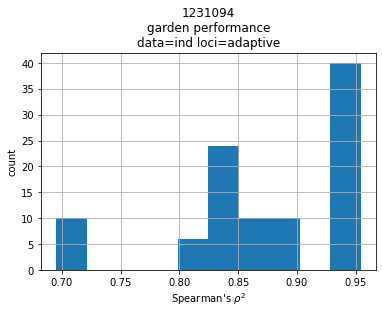

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_ind_adaptive_garden_GF_performance_heatmap.pdf


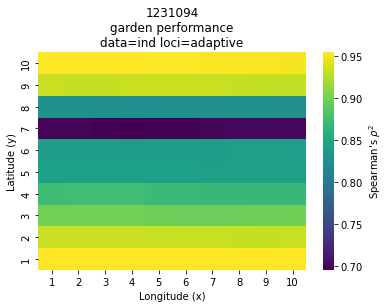

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_ind_adaptive_GF_garden_performance_scatter.pdf


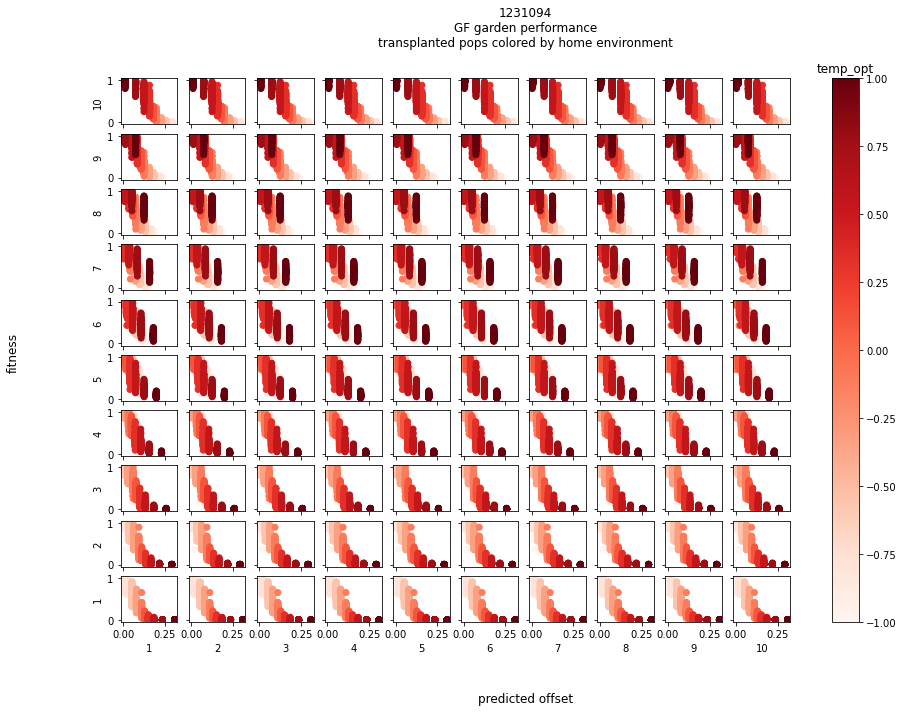

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_garden_slope_heatmap-ind_adaptive.pdf


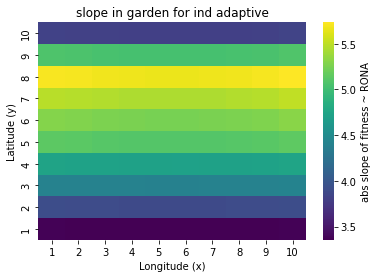

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_ind_adaptive_individual_GF_performance_histogram.pdf


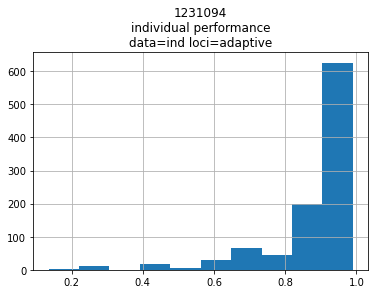

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_ind_adaptive_individual_GF_performance_heatmap.pdf


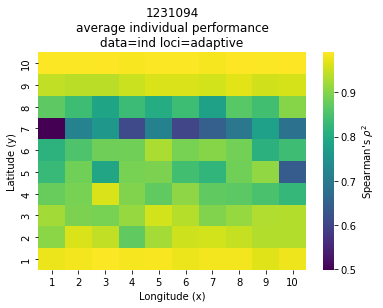

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_source_slope_heatmap-ind_adaptive.pdf


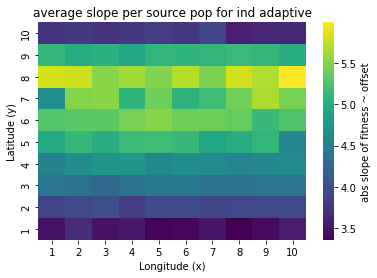

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_ind_adaptive_GF_source_performance_boxplot.pdf


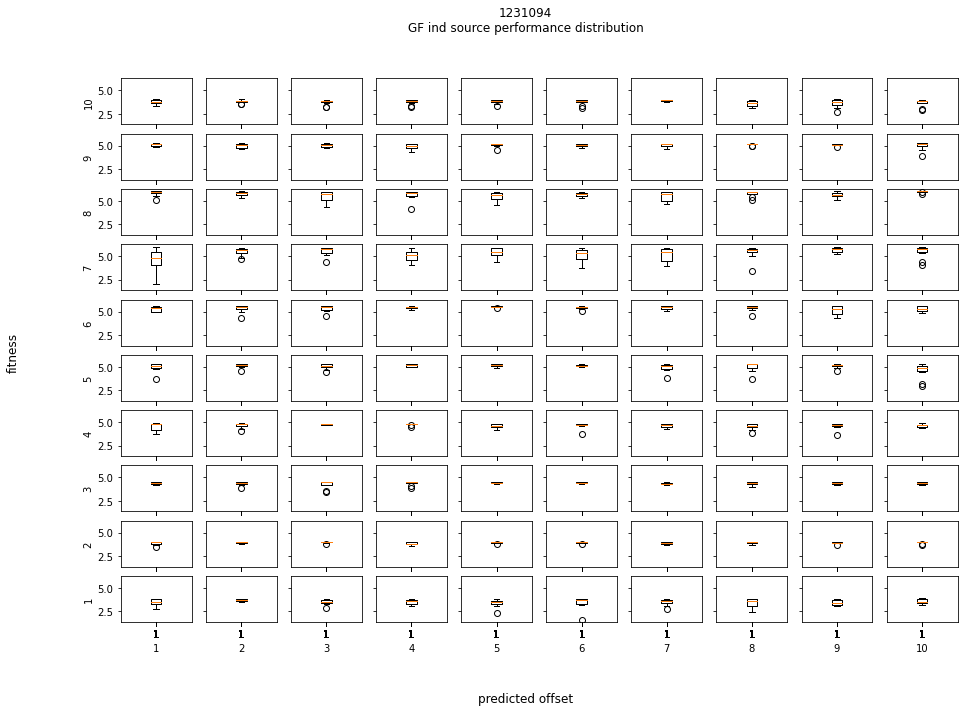

----------------------------------------------
                pooled adaptive               
----------------------------------------------
Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_pooled_adaptive_GF_garden_performance_histogram.pdf


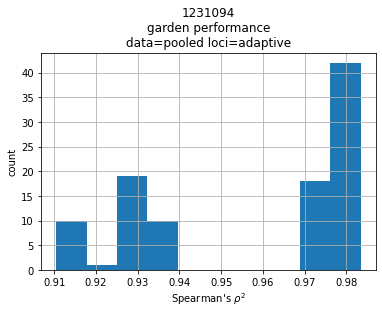

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_pooled_adaptive_garden_GF_performance_heatmap.pdf


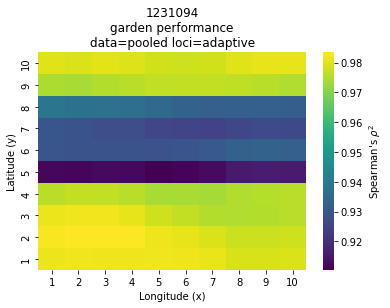

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_pooled_adaptive_GF_garden_performance_scatter.pdf


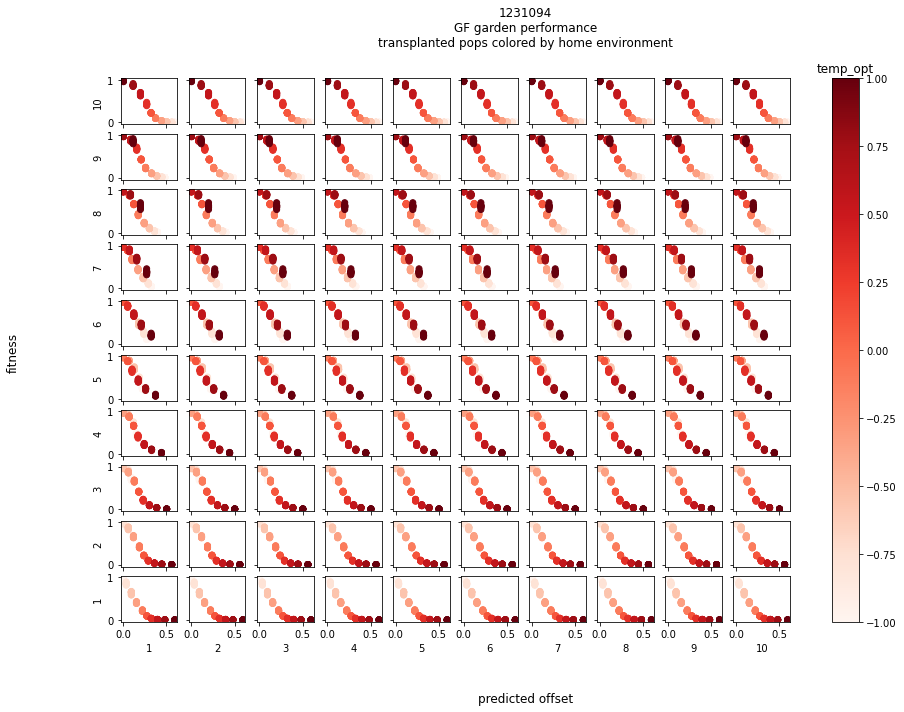

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_garden_slope_heatmap-pooled_adaptive.pdf


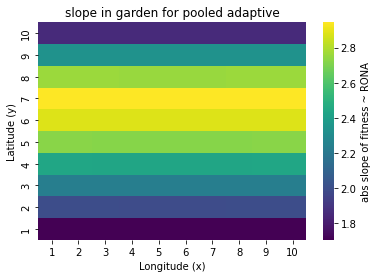

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_pooled_adaptive_source pool_GF_performance_histogram.pdf


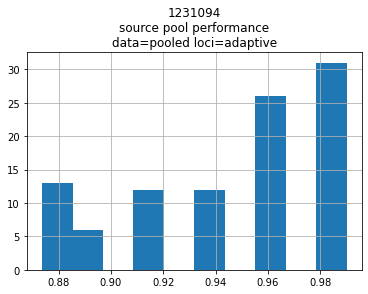

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_pooled_adaptive_individual_GF_performance_heatmap.pdf


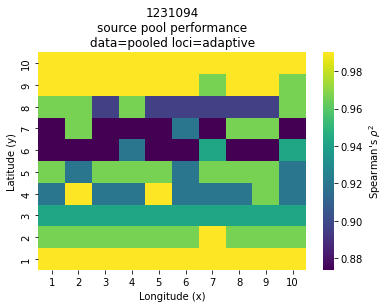

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_source_slope_heatmap-pooled_adaptive.pdf


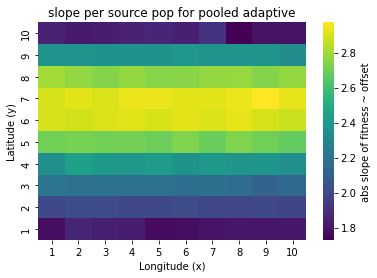

----------------------------------------------
                  pooled all                  
----------------------------------------------
Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_pooled_all_GF_garden_performance_histogram.pdf


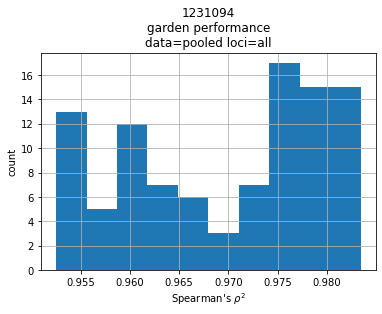

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_pooled_all_garden_GF_performance_heatmap.pdf


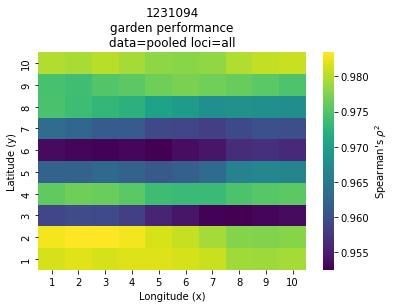

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_pooled_all_GF_garden_performance_scatter.pdf


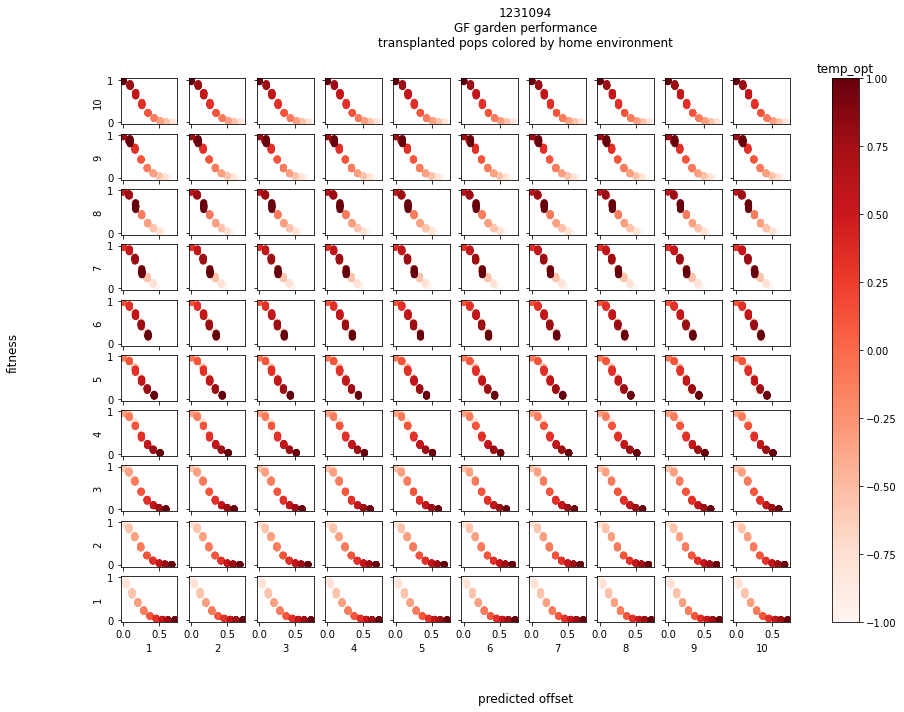

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_garden_slope_heatmap-pooled_all.pdf


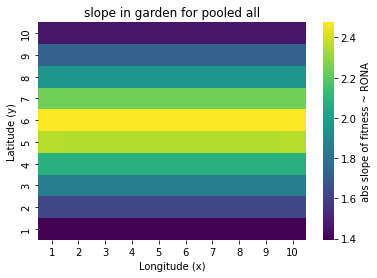

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_pooled_all_source pool_GF_performance_histogram.pdf


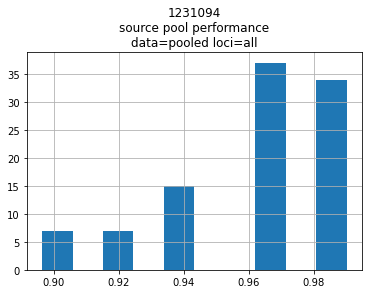

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_pooled_all_individual_GF_performance_heatmap.pdf


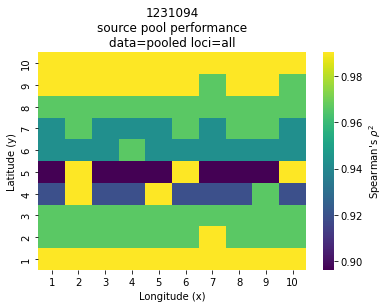

Saved to:  /work/lotterhos/MVP-Offsets/practice_slim/fitting/gradient_forests/figs/1231094_source_slope_heatmap-pooled_all.pdf


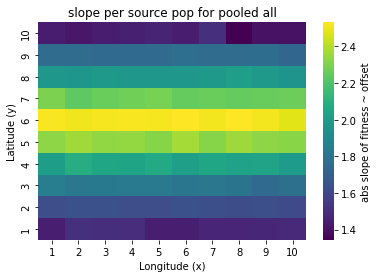

In [11]:
# performance (spearman's rho) and slopes of relationship from fitness ~ RONA
garden_performance = wrap_defaultdict(None, 2)
garden_slopes = wrap_defaultdict(None, 2)
individual_performance = wrap_defaultdict(None, 2)
individual_slopes = wrap_defaultdict(None, 2)
for (ind_or_pooled, adaptive_or_not), offset in unwrap_dictionary(offset_dfs):
    # 1 - GET DATA
    # 1.1 divide figures by dataset when printing
    print_dataset(f'{ind_or_pooled} {adaptive_or_not}')
    
    # 1.2 get the appropriate fitness matrix
    fitness = fitness_mat[ind_or_pooled].copy()
    
    
    # 2 - GARDEN PERFORMANCE - how well offset was predicted at the common garden location across samples
    # 2.1 squared spearman's correlation coefficient (val) for each garden (key)
    garden_performance[ind_or_pooled][adaptive_or_not] = offset.corrwith(fitness,
                                                                         axis='columns',  # across columns for each row
                                                                         method='spearman') ** 2
    # 2.2 plot histogram
    garden_performance[ind_or_pooled][adaptive_or_not].hist()
    title = f'{seed}\ngarden performance\ndata={ind_or_pooled} loci={adaptive_or_not}'
    plt.title(title)
    plt.ylabel('count')
    plt.xlabel("Spearman's $\\rho^2$")
    save_pdf(
        op.join(fig_dir, f'{seed}_{ind_or_pooled}_{adaptive_or_not}_GF_garden_performance_histogram.pdf')
    )
    plt.show()
    
    # 2.3 create heatmap
    create_heatmap(garden_performance[ind_or_pooled][adaptive_or_not],
                   ind_or_pooled,
                   adaptive_or_not,
                   title)
    
    # 2.4 calculate and plot slope of relationship between fitness ~ offset at each garden
    garden_performance_scatter(offset, fitness, ind_or_pooled, adaptive_or_not)
    
    # 2.5 calculate the slope of the linear model between fitness ~ offset at each garden
    garden_performance_slope_heatmap(offset, fitness, ind_or_pooled, adaptive_or_not)
    
    
    # 3 - SAMPLE-LEVEL PERFORMACE - how well performace was predicted for the sample across gardens
    # 3.1 squared spearman's correlation coefficient for each individual or pool
    individual_performance[ind_or_pooled][adaptive_or_not] = offset.corrwith(fitness,
                                                                             axis='index', # across rows for each column
                                                                             method='spearman') ** 2
    # 3.2 plot histogram
    individual_performance[ind_or_pooled][adaptive_or_not].hist()
    name = 'source pool' if ind_or_pooled=='pooled' else 'individual'
    title = f'{seed}\n{name} performance\ndata={ind_or_pooled} loci={adaptive_or_not}'
    plt.title(title)
    save_pdf(
        op.join(fig_dir, f'{seed}_{ind_or_pooled}_{adaptive_or_not}_{name}_GF_performance_histogram.pdf')
    )
    plt.show()

    # 3.3 create heatmap
    create_heatmap(individual_performance[ind_or_pooled][adaptive_or_not],
                   ind_or_pooled,
                   adaptive_or_not,
                   title.replace('individual', 'average individual'),  # replace only happens when 'individual' is in title
                   performance='individual')
    
    # 3.4 calculate and plot slope of relationship between fitness ~ offset for each ind/pool across gardens
    source_performance_slope_heatmap_and_boxplot(offset, fitness, ind_or_pooled, adaptive_or_not)

<a id='envs'></a>
# visualize environments

use these to compare to heatmaps above

[top](#home)

sal_opt
<class 'matplotlib.axes._subplots.AxesSubplot'>


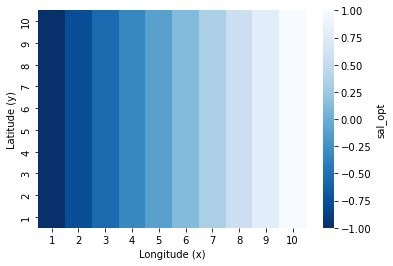

temp_opt
<class 'matplotlib.axes._subplots.AxesSubplot'>


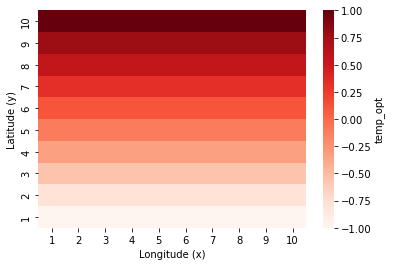

In [12]:
envheats = {}
for env in envdata.columns:
    print(ColorText(env).bold().green())
    
    if env == 'sal_opt':
        colormap = 'Blues_r'
    else:
        colormap = 'Reds'
    
    envdf = blank_dataframe()
    for samp,pop in samppop.items():
        x, y = locations.loc[pop]
        envdf.loc[y, x] = envdata[env].loc[pop]
        
    envheats[env] = sns.heatmap(envdf,
                                cbar_kws={'label': env}, cmap=colormap)
    plt.xlabel('Longitude (x)')
    plt.ylabel('Latitude (y)')
    print(type(envheats[env]))
    plt.show()

In [13]:
# how long to complete notebook?
formatclock(dt.now() - t1, exact=True)

'0-00:01:25'